In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy

# The model

+ Restriction operator is fixed.
+ Petrov-Galerkin coarse-grid correction.
+ Both smoothing operators are adjastable  $\text{conv}D(A)^{-1}\left(b_k - A_k x_k\right)$.
+ Serialization of three layers.

In [2]:
# computes A_k*x_k
def apply_A(x, A, projection_filters, shapes, strides, k):
  if k == 0:
    return A(x)
  else:
    for i in range(k-1, -1, -1):
      x = tf.nn.conv_transpose(x, projection_filters[i], shapes[i], strides[i], padding="VALID")
    x = A(x)
    for i in range(k):
      x = tf.nn.convolution(x, projection_filters[i], strides[i])
    return x

# find diagonal of an emplicitly defined matrix -- works for constant diagonals only
def extract_diagonal(A, projection_filters, shapes, strides, k):
  y = np.zeros(shapes[k].numpy())
  m = shapes[k].numpy()[1]//2 + 1
  y[:, m, m, :] = 1
  y = tf.Variable(y, dtype=projection_filters[0].dtype)
  D = apply_A(y, A, projection_filters, shapes, strides, k)[0, m, m, 0]
  return D

# slightly generalized Jacobi smoother
def smooth_r(x, b, A, D, projection_filters, shapes, strides, smoothing_filter, k):
  r = b - apply_A(x, A, projection_filters, shapes, strides, k)
  x = x + tf.nn.convolution(r/D, smoothing_filter, padding="SAME")
  return x

# for some reason tf.nn.conv_transpose requires shape of an output -- this function compute required shapes
def compute_shapes(J, projection_filters, strides, batch_size=10):
  shapes = []
  x = tf.Variable(np.random.randn(batch_size, 2**J-1, 2**J-1, 1), dtype=projection_filters[0].dtype)
  shapes.append(tf.shape(x))
  for filter, stride in zip(projection_filters, strides):
    x = tf.nn.convolution(x, filter, stride)
    shapes.append(tf.shape(x))
  return shapes

# multigrid
def multigrid_r(x, b, A, projection_filters, shapes, strides, smoothing_filters_pre, smoothing_filters_post, k=0):
  if k == len(projection_filters):
    return b/apply_A(tf.ones_like(b), A, projection_filters, shapes, strides, k)
  else:
    D = extract_diagonal(A, projection_filters, shapes, strides, k)
    x = smooth_r(x, b, A, D, projection_filters, shapes, strides, smoothing_filters_pre[k], k)
    r = b - apply_A(x, A, projection_filters, shapes, strides, k)
    r = tf.nn.convolution(r, projection_filters[k], strides=strides[k])
    e = multigrid_r(tf.zeros_like(r), r, A, projection_filters, shapes, strides, smoothing_filters_pre, smoothing_filters_post, k=k+1)
    e = tf.nn.conv_transpose(e, projection_filters[k], shapes[k], strides=strides[k], padding="VALID")
    x = x + e
    x = smooth_r(x, b, A, D, projection_filters, shapes, strides, smoothing_filters_post[k], k)
    return x

# approximate spectral radius
def stochastic_trace_r(A, J, projection_filters, shapes, strides, smoothing_filters_pre, smoothing_filters_post, N_sweeps=10, batch_size=10):
  x = tf.Variable(np.random.choice([-1, 1], (batch_size, 2**J-1, 2**J-1, 1)), dtype=projection_filters[0].dtype)
  for _ in range(N_sweeps):
    x = multigrid_r(x, x*0, A, projection_filters, shapes, strides, smoothing_filters_pre, smoothing_filters_post)
  return ((tf.norm(x)**2)/batch_size)**(1/(2*N_sweeps))

# Equations

In [3]:
# equations

poisson_filter = tf.Variable(np.array([[0, -1/4, 0], [-1/4, 1, -1/4], [0, -1/4, 0]]).reshape(3, 3, 1, 1), dtype=tf.float32, trainable=False, name="Poisson")
A_poisson = lambda x: tf.nn.convolution(x, poisson_filter, strides=[1, 1], padding="SAME")

poisson_large_filter = tf.Variable(np.array([[0, 0, 1/60, 0, 0], [0, 0, -16/60, 0, 0], [1/60, -16/60, 1, -16/60, 1/60], [0, 0, -16/60, 0, 0], [0, 0, 1/60, 0, 0]]).reshape(5, 5, 1, 1), dtype=tf.float32, trainable=False, name="Poisson large")
A_poisson_large = lambda x: tf.nn.convolution(x, poisson_large_filter, strides=[1, 1], padding="SAME")

mehrstellen_filter = tf.Variable(np.array([[-1/20, -1/5, -1/20], [-1/5, 1, -1/5], [-1/20, -1/5, -1/20]]).reshape(3, 3, 1, 1), dtype=tf.float32, trainable=False, name="Mehrstellen")
A_mehrstellen = lambda x: tf.nn.convolution(x, mehrstellen_filter, strides=[1, 1], padding="SAME")

epsilon = 10
poisson_anisotropic_filter = tf.Variable(np.array([[0, -1/(2+2*epsilon), 0], [-epsilon/(2+2*epsilon), 1, -epsilon/(2+2*epsilon)], [0, -1/(2+2*epsilon), 0]]).reshape(3, 3, 1, 1), dtype=tf.float32, trainable=False, name="Anisotropic Poisson")
A_anisotropic = lambda x: tf.nn.convolution(x, poisson_anisotropic_filter, strides=[1, 1], padding="SAME")

tau = 3/4
mixed_filter = tf.Variable(np.array([[-tau/8, -1/4, tau/8], [-1/4, 1, -1/4], [tau/8, -1/4, -tau/8]]).reshape(3, 3, 1, 1), dtype=tf.float32, trainable=False, name="Mixed")
A_mixed = lambda x: tf.nn.convolution(x, mixed_filter, strides=[1, 1], padding="SAME")

# Training

In [5]:
A = A_poisson # change this line to try different linear equation
N_batch = 10

J = 5
N_levels = J - 1

# we are training three layers -- three variables for presmoothing, three variables for postsmoothing, restriction is fixed
proj_var = tf.Variable(np.outer([1/2, 1, 1/2], [[1/2], [1], [1/2]]).reshape((3, 3, 1, 1))/2, dtype=tf.float32, trainable=False, name="projection_var")
smoothing_pre_var_1 = tf.Variable(np.outer([1/2, 1, 1/2], [[1/2], [1], [1/2]]).reshape((3, 3, 1, 1)), dtype=tf.float32, trainable=True, name="presmoothing_var 1")
smoothing_post_var_1 = tf.Variable(np.outer([1/2, 1, 1/2], [[1/2], [1], [1/2]]).reshape((3, 3, 1, 1)), dtype=tf.float32, trainable=True, name="postsmoothing_var 1")
smoothing_pre_var_2 = tf.Variable(np.outer([1/2, 1, 1/2], [[1/2], [1], [1/2]]).reshape((3, 3, 1, 1)), dtype=tf.float32, trainable=True, name="presmoothing_var 2")
smoothing_post_var_2 = tf.Variable(np.outer([1/2, 1, 1/2], [[1/2], [1], [1/2]]).reshape((3, 3, 1, 1)), dtype=tf.float32, trainable=True, name="postsmoothing_var 2")
smoothing_pre_var_3 = tf.Variable(np.outer([1/2, 1, 1/2], [[1/2], [1], [1/2]]).reshape((3, 3, 1, 1)), dtype=tf.float32, trainable=True, name="presmoothing_var 3")
smoothing_post_var_3 = tf.Variable(np.outer([1/2, 1, 1/2], [[1/2], [1], [1/2]]).reshape((3, 3, 1, 1)), dtype=tf.float32, trainable=True, name="postsmoothing_var 3")
smoothing_pre_var = [smoothing_pre_var_1, smoothing_pre_var_2, smoothing_pre_var_3]
smoothing_post_var = [smoothing_post_var_1, smoothing_post_var_2, smoothing_post_var_3]

projection_filters = [proj_var for i in range(N_levels)]
smoothing_filters_pre = [smoothing_pre_var[i%3] for i in range(N_levels)]
smoothing_filters_post = [smoothing_post_var[i%3] for i in range(N_levels)]
variables = smoothing_pre_var + smoothing_post_var

strides = [[2, 2]]*N_levels
shapes = compute_shapes(J, projection_filters, strides, batch_size=N_batch)

In [6]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
N_epoch = 200

history = np.zeros(N_epoch)
for i in range(N_epoch):
  with tf.GradientTape() as tape:
    loss = stochastic_trace_r(A, J, projection_filters, shapes, strides, smoothing_filters_pre, smoothing_filters_post)
  opt.apply_gradients(zip(tape.gradient(loss, variables), variables))
  history[i] = loss.numpy()

final loss =  0.037872486


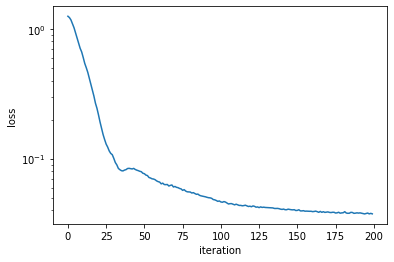

In [7]:
# training history
final_loss = stochastic_trace_r(A, J, projection_filters, shapes, strides, smoothing_filters_pre, smoothing_filters_post, N_sweeps=10, batch_size=10).numpy()
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.plot(history)
ax.set_xlabel("iteration")
ax.set_ylabel("loss")
print("final loss = ", final_loss);

# Model evaluation

In [8]:
N_batch = 10

for J in [3, 4, 5, 6, 7, 8, 9, 10, 11]:
  N_levels = J - 1

  # serialization
  projection_filters_ = [proj_var for i in range(N_levels)]
  smoothing_filters_pre_ = [smoothing_pre_var[i%3] for i in range(N_levels)]
  smoothing_filters_post_ = [smoothing_post_var[i%3] for i in range(N_levels)]

  strides_ = [[2, 2]]*N_levels
  shapes_ = compute_shapes(J, projection_filters_, strides_, batch_size=N_batch)
  spectral_radius = stochastic_trace_r(A, J, projection_filters_, shapes_, strides_, smoothing_filters_pre_, smoothing_filters_post_, N_sweeps=10, batch_size=10).numpy()
  print("J = ", J, " spectral radius = ", spectral_radius)

J =  3  spectral radius =  0.026539112
J =  4  spectral radius =  0.033393394
J =  5  spectral radius =  0.03776223
J =  6  spectral radius =  0.046081044
J =  7  spectral radius =  0.055237
J =  8  spectral radius =  0.061990507
J =  9  spectral radius =  0.068533845
J =  10  spectral radius =  0.07517537
J =  11  spectral radius =  0.08136343
